In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdisplaced_dark = delphes_dir + "displacedPhoton/dark_events.root"
fdisplaced_half = delphes_dir + "displacedPhoton/displaced_half_dark_events.root"
fprompt_half = delphes_dir + "displacedPhoton/prompt_half_dark_events.root"
fprompt_non_dark = delphes_dir + "displacedPhoton/non_dark_events.root"
df_displaced_dark = ROOT.RDataFrame("Delphes", fdisplaced_dark)
df_displaced_half = ROOT.RDataFrame("Delphes", fdisplaced_half)
df_prompt_half = ROOT.RDataFrame("Delphes", fprompt_half)
df_prompt_non_dark = ROOT.RDataFrame("Delphes", fprompt_non_dark)


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
def create_missingET_dataframe(root_file_path):
    # Load the ROOT file into an RDataFrame
    rdf = ROOT.RDataFrame("Delphes", root_file_path)
    
    # Convert the specified properties to a dictionary of numpy arrays
    missingET_dict = rdf.AsNumpy([
        "Event.Number",
        "MissingET.MET",
        "MissingET.Phi",
        "GenMissingET.MET",
        "GenMissingET.Phi",
    ])
    
    # Flatten event numbers (scalars, not 1-element arrays)
    event_numbers = [arr[0] for arr in missingET_dict["Event.Number"]]
    
    # Build the DataFrame
    missingET_df = pd.DataFrame({
        "EventNumber": event_numbers,
        "MissingET_MET": missingET_dict["MissingET.MET"],
        "MissingET_Phi": missingET_dict["MissingET.Phi"],
        "GenMissingET_MET": missingET_dict["GenMissingET.MET"],
        "GenMissingET_Phi": missingET_dict["GenMissingET.Phi"],
    })
    
    # Explode so each entry gets its own row
    missingET_df = missingET_df.explode(
        ["MissingET_MET", "MissingET_Phi", 
         "GenMissingET_MET", "GenMissingET_Phi"], 
        ignore_index=True
    )

    # Sort by EventNumber and reset the index
    missingET_df = missingET_df.sort_values(by="EventNumber").reset_index(drop=True)
    
    return missingET_df

In [3]:
displaced_dark_df = create_missingET_dataframe(fdisplaced_dark)
displaced_half_df = create_missingET_dataframe(fdisplaced_half)
prompt_half_df = create_missingET_dataframe(fprompt_half)
prompt_non_dark_df = create_missingET_dataframe(fprompt_non_dark)
displaced_dark_df

,EventNumber,MissingET_MET,MissingET_Phi,GenMissingET_MET,GenMissingET_Phi
0,0,16.621162,-1.200758,65.756493,-0.913688
1,1,17.432323,-1.338993,29.189962,-2.816309
2,2,36.618279,2.605128,40.324047,2.954522
3,3,52.176125,-0.002952,55.542053,-0.242607
4,4,32.664673,-1.563951,30.059149,-1.76334
...,...,...,...,...,...
3995,3995,407.082581,2.593266,455.278961,2.604759
3996,3996,26.90897,-2.376417,41.253624,-2.541027
3997,3997,32.670761,0.534935,24.704882,0.144974
3998,3998,47.516613,1.126658,65.420845,1.389274


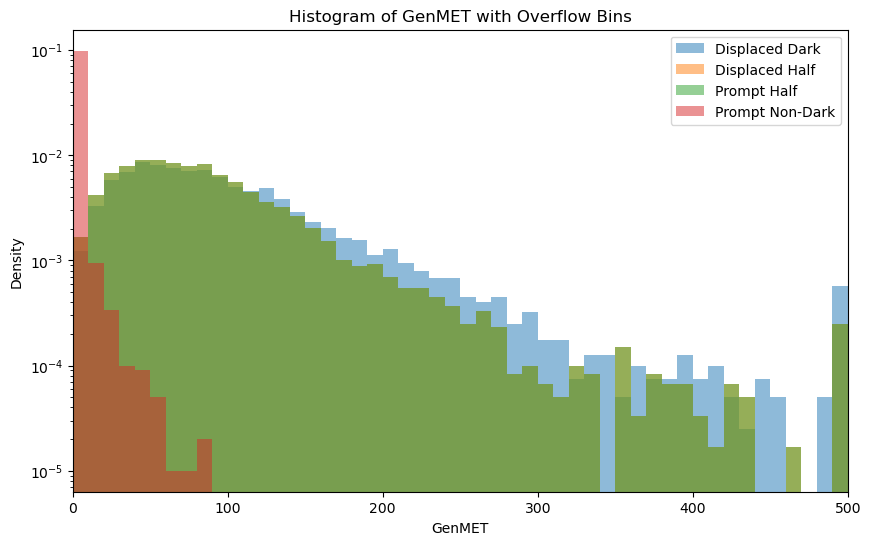

In [18]:
# Plot histograms of GenMissingET_MET for each dataset with overflow bins and xlim
plt.figure(figsize=(10, 6))

# Define bins with an overflow bin
bins = np.linspace(0, 500, 51)  # 50 bins from 0 to 500

# Plot histograms
plt.hist(np.clip(displaced_dark_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Dark", density=True)
plt.hist(np.clip(displaced_half_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Half", density=True)
plt.hist(np.clip(prompt_half_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Half", density=True)
plt.hist(np.clip(prompt_non_dark_df["GenMissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Non-Dark", density=True)

# Add labels, legend, and set xlim
plt.xlabel("GenMET")
plt.ylabel("Density")
plt.yscale('log')
plt.xlim(0, 500)
plt.title("Histogram of GenMET with Overflow Bins")
plt.legend()
plt.show()

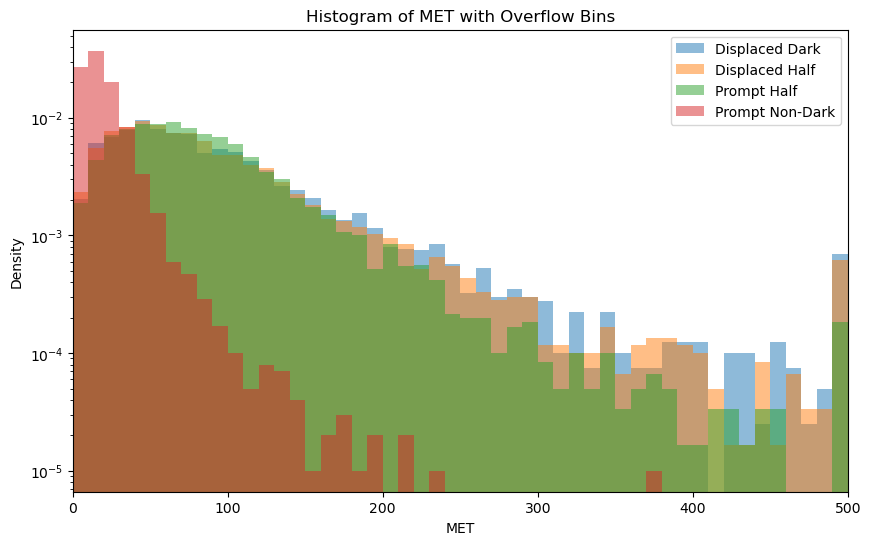

In [17]:
# Plot histograms of MissingET_MET for each dataset with overflow bins and xlim
plt.figure(figsize=(10, 6))

# Define bins with an overflow bin
bins = np.linspace(0, 500, 51)  # 50 bins from 0 to 500

# Plot histograms
plt.hist(np.clip(displaced_dark_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Dark", density=True)
plt.hist(np.clip(displaced_half_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Displaced Half", density=True)
plt.hist(np.clip(prompt_half_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Half", density=True)
plt.hist(np.clip(prompt_non_dark_df["MissingET_MET"].astype(float), bins[0], bins[-1]), bins=bins, alpha=0.5, label="Prompt Non-Dark", density=True)

# Add labels, legend, and set xlim
plt.xlabel("MET")
plt.ylabel("Density")
plt.yscale('log')
plt.xlim(0, 500)
plt.title("Histogram of MET with Overflow Bins")
plt.legend()
plt.show()

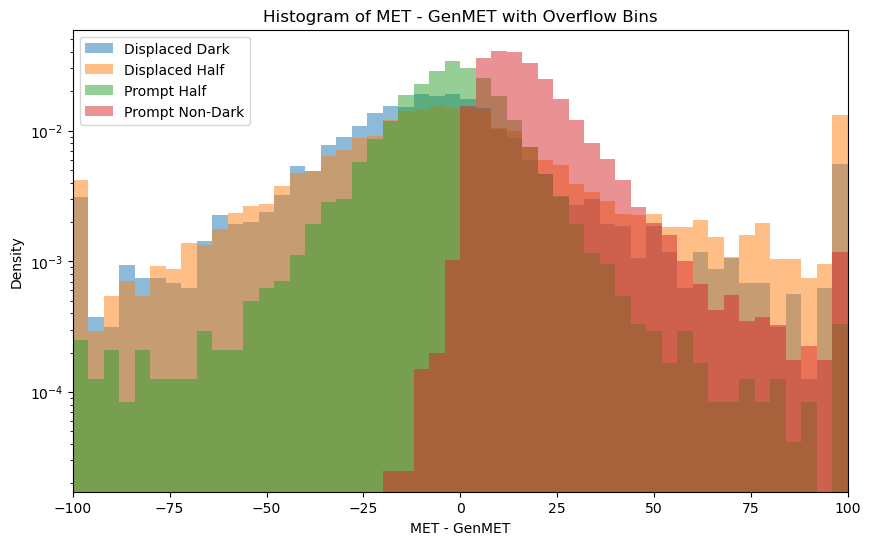

In [16]:
# Plot histograms of MissingET_MET - GenMissingET_MET for each dataset with overflow bins and xlim
plt.figure(figsize=(10, 6))

# Define bins with an x-range of -100 to 100
bins = np.linspace(-100, 100, 51)  # 50 bins from -100 to 100

# Plot histograms
plt.hist(
    np.clip(
        displaced_dark_df["MissingET_MET"].astype(float) - displaced_dark_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Displaced Dark", density=True
)
plt.hist(
    np.clip(
        displaced_half_df["MissingET_MET"].astype(float) - displaced_half_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Displaced Half", density=True
)
plt.hist(
    np.clip(
        prompt_half_df["MissingET_MET"].astype(float) - prompt_half_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Prompt Half", density=True
)
plt.hist(
    np.clip(
        prompt_non_dark_df["MissingET_MET"].astype(float) - prompt_non_dark_df["GenMissingET_MET"].astype(float),
        bins[0], bins[-1]
    ),
    bins=bins, alpha=0.5, label="Prompt Non-Dark", density=True
)

# Add labels, legend, and set xlim
plt.xlabel("MET - GenMET")
plt.ylabel("Density")
plt.yscale('log')
plt.xlim(-100, 100)
plt.title("Histogram of MET - GenMET with Overflow Bins")
plt.legend()
plt.show()

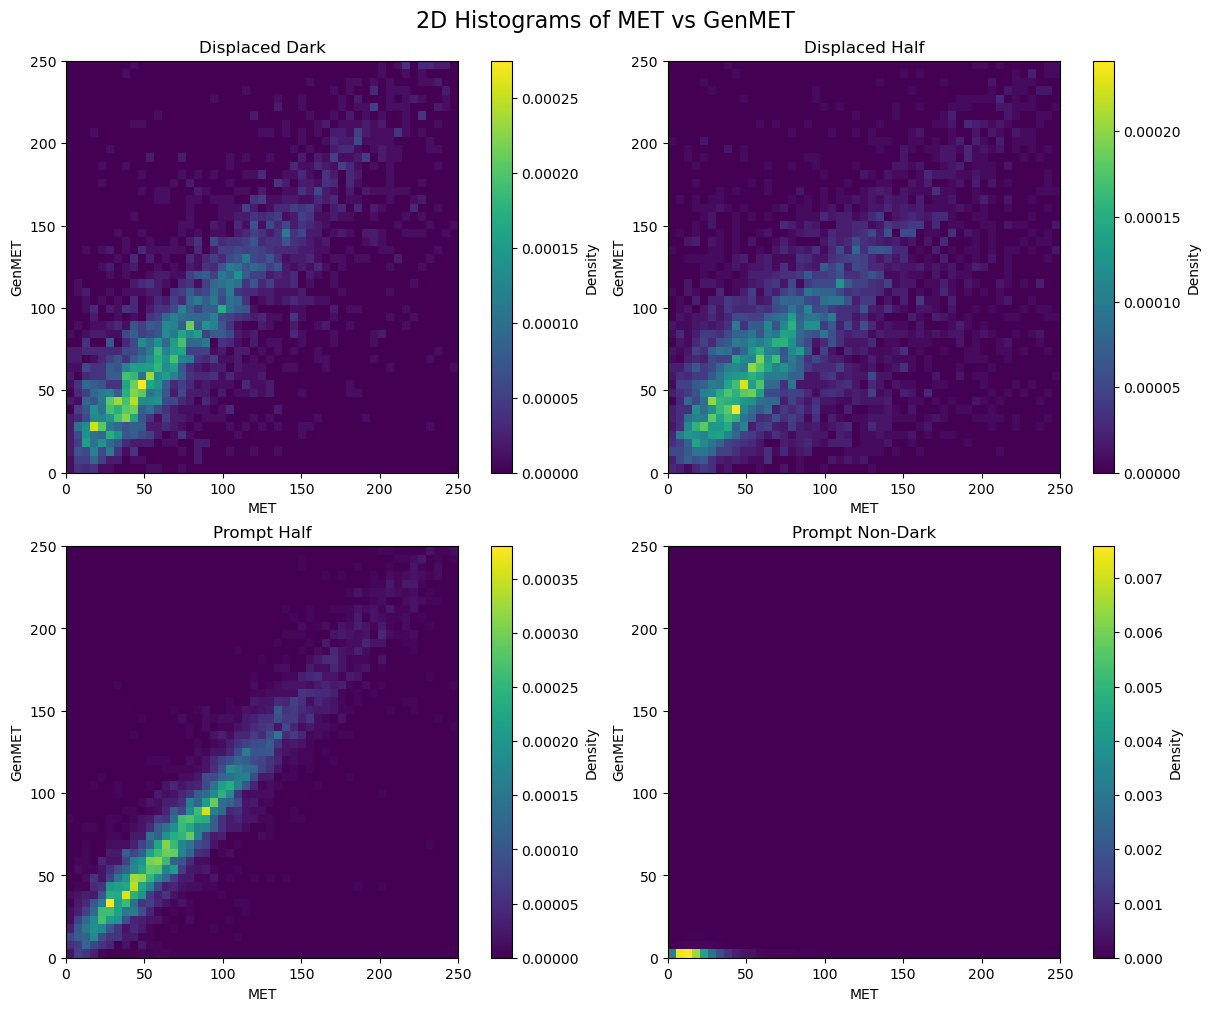

In [20]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Define the datasets and titles
datasets = [
    (displaced_dark_df, "Displaced Dark"),
    (displaced_half_df, "Displaced Half"),
    (prompt_half_df, "Prompt Half"),
    (prompt_non_dark_df, "Prompt Non-Dark"),
]

# Define the bin edges for MET and GenMET
met_bins = np.linspace(0, 250, 50)
genmet_bins = np.linspace(0, 250, 50)

# Loop through datasets and plot 2D histograms
for ax, (df, title) in zip(axes.flatten(), datasets):
    h, xedges, yedges, img = ax.hist2d(
        df["MissingET_MET"].astype(float),
        df["GenMissingET_MET"].astype(float),
        bins=[met_bins, genmet_bins],
        density=True,
        cmap="viridis",
    )
    ax.set_title(title)
    ax.set_xlabel("MET")
    ax.set_ylabel("GenMET")
    fig.colorbar(img, ax=ax, label="Density")

# Show the plot
plt.suptitle("2D Histograms of MET vs GenMET", fontsize=16)
plt.show()

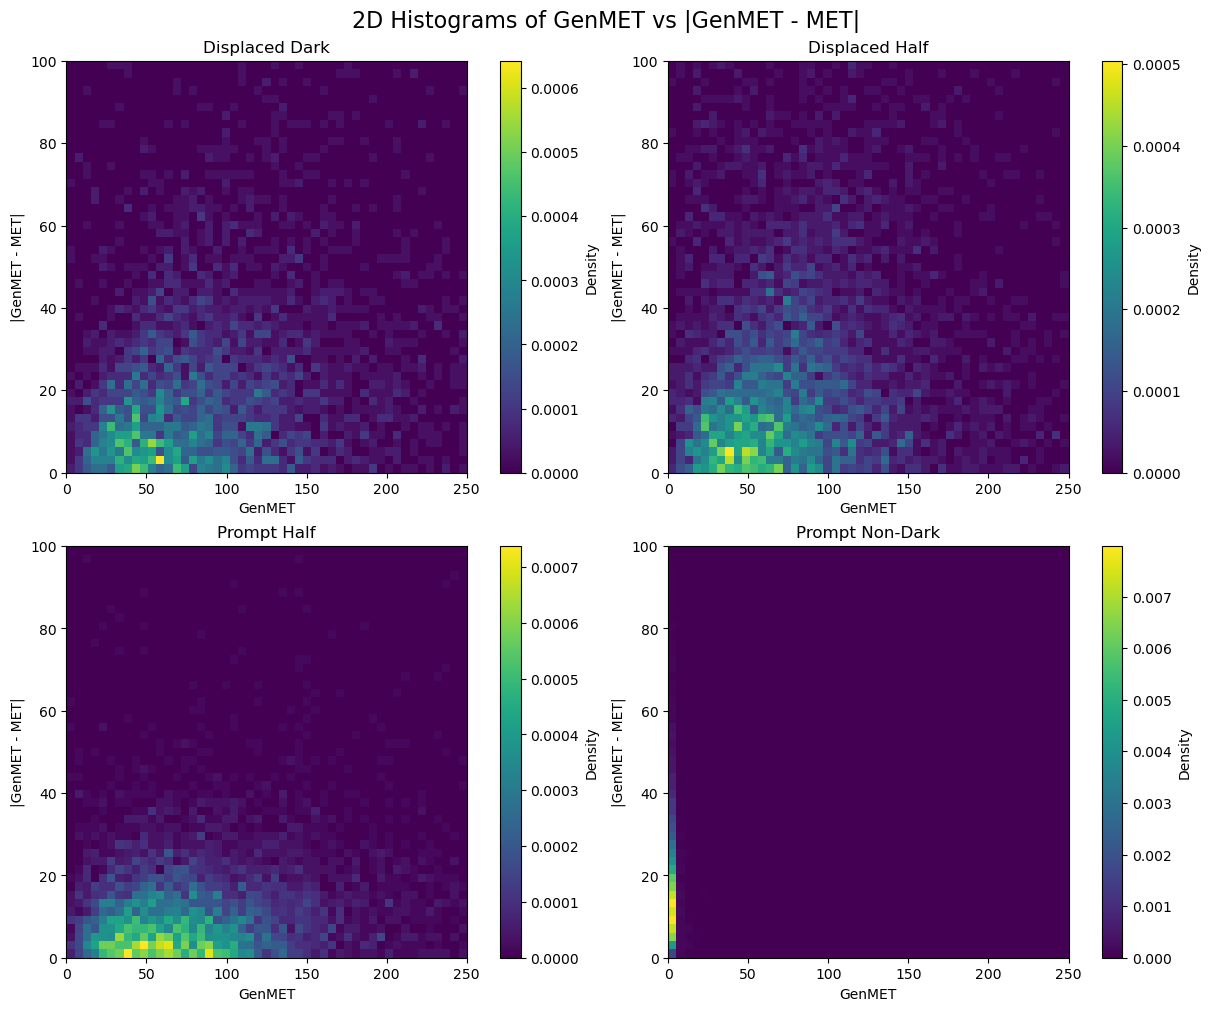

In [24]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Define the datasets and titles
datasets = [
    (displaced_dark_df, "Displaced Dark"),
    (displaced_half_df, "Displaced Half"),
    (prompt_half_df, "Prompt Half"),
    (prompt_non_dark_df, "Prompt Non-Dark"),
]

# Define the bin edges for GenMET and dMET
met_bins = np.linspace(0, 250, 50)
dmet_bins = np.linspace(0, 100, 50)

# Loop through datasets and plot 2D histograms
for ax, (df, title) in zip(axes.flatten(), datasets):
    h, xedges, yedges, img = ax.hist2d(
        df["GenMissingET_MET"].astype(float),
        np.abs(df["GenMissingET_MET"].astype(float) - df["MissingET_MET"].astype(float)),
        bins=[met_bins, dmet_bins],
        density=True,
        cmap="viridis",
    )
    ax.set_title(title)
    ax.set_xlabel("GenMET")
    ax.set_ylabel("|GenMET - MET|")
    fig.colorbar(img, ax=ax, label="Density")

# Show the plot
plt.suptitle("2D Histograms of GenMET vs |GenMET - MET|", fontsize=16)
plt.show()

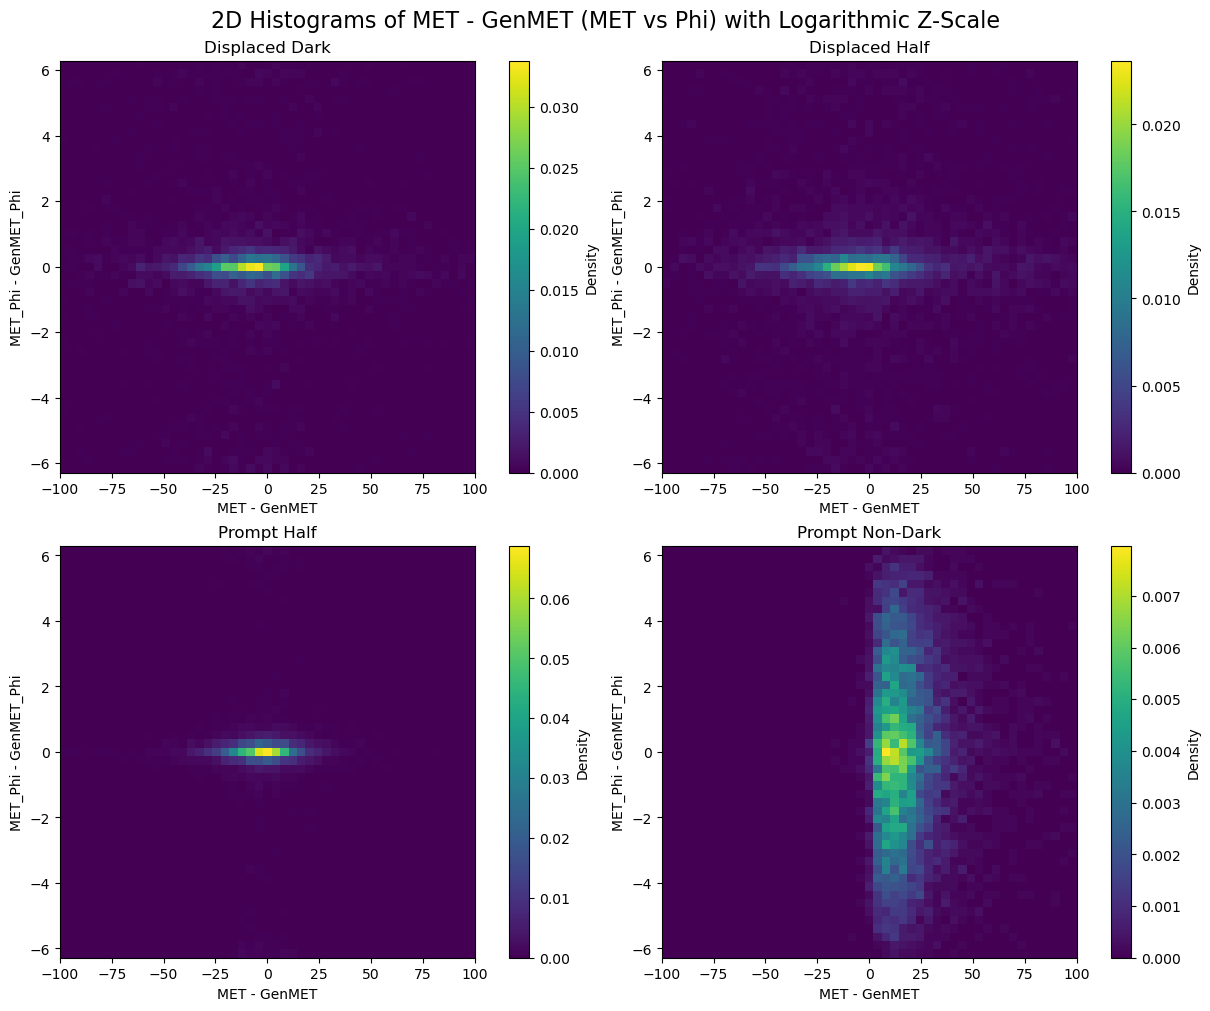

In [26]:
from matplotlib.colors import LogNorm

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Define the datasets and titles
datasets = [
    (displaced_dark_df, "Displaced Dark"),
    (displaced_half_df, "Displaced Half"),
    (prompt_half_df, "Prompt Half"),
    (prompt_non_dark_df, "Prompt Non-Dark"),
]

# Define the bin edges for met and phi differences
met_diff_bins = np.linspace(-100, 100, 50)
phi_diff_bins = np.linspace(-2*np.pi, 2*np.pi, 50)

# Loop through datasets and plot 2D histograms
for ax, (df, title) in zip(axes.flatten(), datasets):
    h, xedges, yedges, img = ax.hist2d(
        df["MissingET_MET"].astype(float) - df["GenMissingET_MET"].astype(float),
        df["MissingET_Phi"].astype(float) - df["GenMissingET_Phi"].astype(float),
        bins=[met_diff_bins, phi_diff_bins],
        density=True,
        cmap="viridis",
        # norm=LogNorm(),  # Set logarithmic scale for z-space
    )
    ax.set_title(title)
    ax.set_xlabel("MET - GenMET")
    ax.set_ylabel("MET_Phi - GenMET_Phi")
    fig.colorbar(img, ax=ax, label="Density")

# Show the plot
plt.suptitle("2D Histograms of MET - GenMET (MET vs Phi) with Logarithmic Z-Scale", fontsize=16)
plt.show()